In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet

from joblib import dump, load

from permetrics.regression import RegressionMetric

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
proj_dir = Path('../../..')
# specify the project directory and file paths
geopackage_fn = (
    proj_dir / "data/gis/geopackages/columbia_river_basin.gpkg"
)  

seed = 1993

In [ ]:
reaches = gpd.read_file(geopackage_fn, layer='Reaches')
reaches.rename(columns={'reach_id': 'Name'}, inplace=True)

In [ ]:
ml_input_data = pd.read_csv(proj_dir / 'methods/04-ml_development/input_data/ml_input_data.csv')

In [5]:
ml_input_data = ml_input_data.merge(
    reaches[["Name", "DistToUpDam", "DistToDownDam", "UpDamGrandID", "DownDamGrandID"]],
    on="Name",
)

In [6]:
# shuffle the data and divide into training and testing
ml_input_data = ml_input_data.sample(frac=1).reset_index(drop=True)
ml_input_data.dropna(subset=['LandTempC', 'NDVI', 'UpDamGrandID'], inplace=True)

# ml_input_data.sort_values(by='Date')

In [7]:
ml_input_data["Date"] = pd.to_datetime(ml_input_data["Date"])

dels = pd.read_csv(proj_dir / "Methods/02-ML_development/var2_40yrs/rat_dels.csv")
dels["Date"] = pd.to_datetime(dels["Date"])
sarea = pd.read_csv(proj_dir / "Methods/02-ML_development/var2_40yrs/rat_sarea.csv")
sarea["Date"] = pd.to_datetime(sarea["Date"])

In [8]:
# # group the ml data by reach name and resammples to SMS
# ml_input_data = ml_input_data.groupby("Name").resample("SMS", on="Date", ).mean(numeric_only=True).reset_index()
# dels = dels.groupby("GranD_ID").resample("SMS", on="Date").mean(numeric_only=True).drop("GranD_ID", axis=1).reset_index()   
# sarea = sarea.groupby("GranD_ID").resample("SMS", on="Date").mean(numeric_only=True).drop("GranD_ID", axis=1).reset_index()   
# # ml_input_data

In [9]:
ml_input_data['DOM'] = ml_input_data['Date'].dt.day
ml_input_data['Year'] = ml_input_data['Date'].dt.year
ml_input_data['Month'] = ml_input_data['Date'].dt.month

ml_input_data = ml_input_data.dropna(subset=['LandTempC', 'NDVI', 'UpDamGrandID'])
ml_input_data['GranD_ID'] = np.int64(ml_input_data['UpDamGrandID'])

In [10]:
ml_input_data = ml_input_data.merge(dels, on = ['GranD_ID', 'Date'], how = 'left')
ml_input_data = ml_input_data.merge(sarea, on = ['GranD_ID', 'Date'], how = 'left')

# filter data within 50 km of a dam
# ml_input_data = ml_input_data[ml_input_data['DistToUpDam'] <= 50]

In [11]:
ml_input_data.rename(columns={"dS (m3)": "dels", "area (km2)": "sarea"}, inplace=True)

In [12]:
ml_input_data.dropna(subset=['dels', 'sarea'], inplace=True)

<Axes: xlabel='avg_temp(C)', ylabel='WaterTempC'>

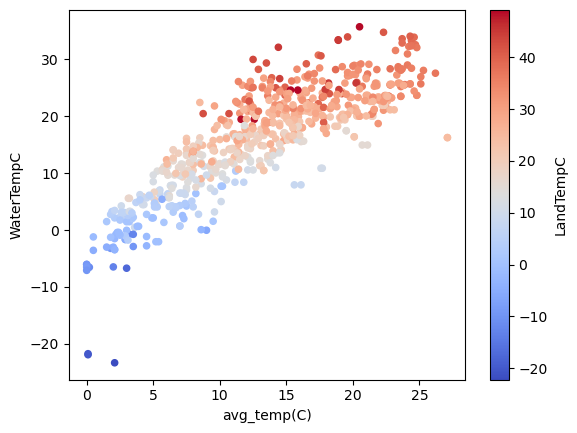

In [13]:
ml_input_data.plot.scatter(x='avg_temp(C)', y='WaterTempC', c='LandTempC', cmap='coolwarm')

In [14]:
ml_input_data

,Date,outflow(m3/d),inflow(m3/d),spill(m3/d),avg_temp(C),wse(m),station_ID,RKm,Name,wse_tail(m),...,DistToUpDam,DistToDownDam,UpDamGrandID,DownDamGrandID,DOM,Year,Month,GranD_ID,dels,sarea
15,2023-07-15,9.957546e+06,NaN,NaN,16.70,NaN,USGS_13013650,1580,Snake_River_159,NaN,...,48.557434,115.841179,384.0,396.0,15,2023,7,384,3.241106e+08,183.51760
24,2022-08-15,3.581781e+08,3.322444e+08,171260.0064,18.17,NaN,DART_GCGW,950,Columbia_River_96,294.235632,...,9.149815,73.202395,310.0,NaN,15,2022,8,310,-2.394928e+04,49.36480
55,2021-06-01,2.329136e+07,NaN,NaN,14.90,NaN,USGS_12447200,20,Okanogan_River_3,NaN,...,108.043829,NaN,291.0,NaN,1,2021,6,291,-4.267318e+05,42.02600
105,2016-11-01,NaN,NaN,NaN,9.40,NaN,USGS_12447302,10,Okanogan_River_2,NaN,...,118.043832,NaN,291.0,NaN,1,2016,11,291,1.917433e+07,47.56700
120,2022-10-15,3.205009e+06,NaN,NaN,9.60,NaN,USGS_13018750,1540,Snake_River_155,NaN,...,88.557432,75.841181,384.0,396.0,15,2022,10,384,-3.763488e+08,164.12000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15286,2022-07-01,NaN,NaN,NaN,15.50,NaN,USGS_12398550,20,Pend_Oreille_River_3,NaN,...,6.171532,9.812808,290.0,287.0,1,2022,7,290,7.397192e+06,1.69800
15328,2011-10-01,8.905520e+06,NaN,NaN,14.50,NaN,USGS_13038500,1370,Snake_River_138,NaN,...,94.158819,200.924358,396.0,411.0,1,2011,10,396,-1.774858e+08,113.45150
15351,2007-11-15,4.991006e+06,NaN,NaN,8.00,NaN,USGS_13069500,1220,Snake_River_123,NaN,...,244.158823,50.924354,396.0,411.0,15,2007,11,396,-5.516311e+08,86.42400
15389,2017-03-01,1.326042e+07,NaN,NaN,6.20,NaN,USGS_14092500,160,Deschutes_River_17,NaN,...,8.327241,NaN,81.0,NaN,1,2017,3,81,-1.566303e+06,3.91600


In [15]:
features = [
    "NDVI",
    "LandTempC",
    "ClimateClass",
    # "DOY",
    # "WidthMin",
    "WidthMean",
    # "WidthMax",
    # "WaterTempC",
    'DOM', 'Month',
    'dels', 'sarea', 'DistToUpDam'
]
y_col = "avg_temp(C)"

In [16]:
model_name = "RFR2_all_downstream_distances"

cv_splitter = RepeatedKFold(n_splits=5, 
                    n_repeats=10, 
                    random_state=seed
                    )

In [17]:
dev_set, test_set = train_test_split(ml_input_data, test_size=0.2, random_state=seed)

# add the data from the handpicked reaches to the test set
dev_set = dev_set[
    ~(
        (
            (dev_set["Name"] == "Okanogan_River_13")
            | (dev_set["Name"] == "Columbia_River_96")
            | (dev_set["Name"] == "Kootenay_River_35")
            | (dev_set["Name"] == "Willamette_River_20")
        )
        & (dev_set["Date"] > "2020-01-01")
    )
].copy()

test_set = pd.concat(
    [test_set, dev_set[
        (
            (dev_set["Name"] == "Okanogan_River_13")
            | (dev_set["Name"] == "Columbia_River_96")
            | (dev_set["Name"] == "Kootenay_River_35")
            | (dev_set["Name"] == "Willamette_River_20")
        )
        & (dev_set["Date"] > "2020-01-01")
    ]],
    
).copy()

In [18]:
hyperparmeters = {
    "n_estimators": [10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 1000],
    # 'n_estimators': [100],
}

list_metrics = ["RMSE", "MAE", "NSE", "R2", "KGE", "MSE"]

dev_results = pd.DataFrame(columns=["parameters", "combination", "fold"] + list_metrics)

test_results = pd.DataFrame(columns=["parameters", "combination"] + list_metrics)

# for i, l1_ratio in enumerate(hyperparmeters['l1_ratio']):
for i, params in enumerate(ParameterGrid(hyperparmeters)):
    n_estimators = params["n_estimators"]
    for j, (train_idx, val_idx) in enumerate(cv_splitter.split(dev_set)):
        train_set = dev_set.iloc[train_idx].copy()
        val_set = dev_set.iloc[val_idx].copy()

        X_train = train_set[features]
        y_train = train_set[y_col]

        X_val = val_set[features]
        y_val = val_set[y_col]

        model = RandomForestRegressor(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        val_set["y_pred"] = y_pred

        # mse = mean_squared_error(y_val, y_pred)
        # rmse = np.sqrt(mse)
        # r2 = r2_score(y_val, y_pred)
        # # nse = 1 - mse / np.var(y_val)
        # mae = np.mean(np.abs(y_val - y_pred))

        evaluator = RegressionMetric(list(y_val), list(y_pred))

        dev_results = pd.concat(
            [
                dev_results,
                pd.DataFrame(
                    [
                        [params, i, j]
                        + list(
                            evaluator.get_metrics_by_list_names(list_metrics).values()
                        )
                    ],
                    columns=["parameters", "combination", "fold"] + list_metrics,
                    index=[j],
                ),
            ]
        )

    X_dev = dev_set[features]
    y_dev = dev_set[y_col]

    X_test = test_set[features]
    y_test = test_set[y_col]

    model = RandomForestRegressor(n_estimators=n_estimators, random_state=seed)
    model.fit(X_dev, y_dev)

    y_pred = model.predict(X_test)

    test_set["y_pred"] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # nse = 1 - mse / np.var(y_val)
    mae = np.mean(np.abs(y_test - y_pred))

    evaluator = RegressionMetric(list(y_test), list(y_pred))

    test_results = pd.concat(
        [
            test_results,
            pd.DataFrame(
                [
                    [params, i]
                    + list(evaluator.get_metrics_by_list_names(list_metrics).values())
                ],
                columns=["parameters", "combination"] + list_metrics,
                index=[i],
            ),
        ]
    )

test_results['n_estimators'] = test_results['parameters'].apply(lambda x: x['n_estimators'])
dev_results['n_estimators'] = dev_results['parameters'].apply(lambda x: x['n_estimators'])

dev_results.to_csv(
    f"{model_name}_dev_results.csv", index=False
)
test_results.to_csv(
    f"{model_name}_test_results.csv", index=False
)

In [22]:
test_results["delta_MSE"] = np.abs(test_results["MSE"] - test_results["MSE"].shift(1))

# find the set of hyperparmeters with a patience of 5 for delta MSE at 0.005
patience = 4
delta = 0.005

test_results["patience"] = test_results["delta_MSE"].apply(lambda x: 1 if x < delta else 0)
test_results["patience"] = test_results["patience"] + test_results["patience"].shift(-1) + test_results["patience"].shift(-2) + test_results["patience"].shift(-3) + test_results["patience"].shift(-4)

# get the first hyperparmeters with the patience of 5
# best_hyperparameters = test_results[test_results["patience"] == patience].iloc[0]["parameters"]
best_hyperparameters = {"n_estimators": 350}
# save the best hyperparmeters
with open(f"{model_name}_params.json", "w") as f:
            json.dump(best_hyperparameters, f)

In [18]:
# final_model = RandomForestRegressor(n_estimators=best_hyperparameters["n_estimators"], random_state=seed)
final_model = RandomForestRegressor(n_estimators=350, random_state=seed)
final_model.fit(dev_set[features], dev_set[y_col])

test_set["y_pred"] = final_model.predict(test_set[features])
test_set.to_csv(f"{model_name}_test_set.csv", index=False)

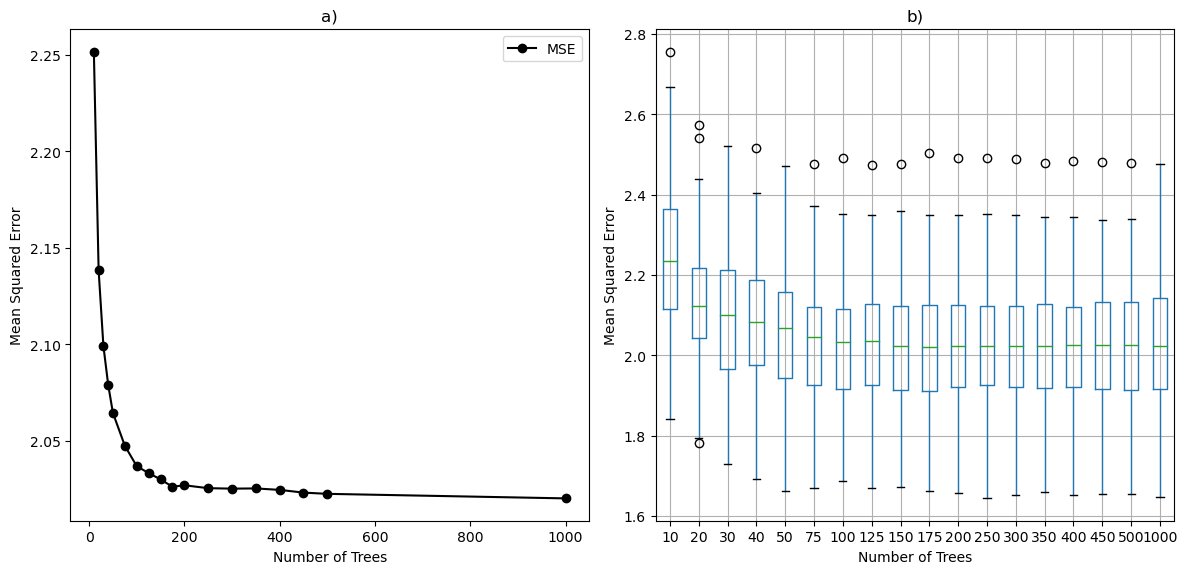

In [24]:
# boxplot and mean line of the dev results for each parameter
fig, ax = plt.subplots(1,2, figsize=(12, 6))
dev_results.boxplot(column='MSE', by='n_estimators', ax=ax[1])
dev_results.groupby('n_estimators').mean(numeric_only=True).plot(y='MSE', ax=ax[0], color='black', marker='o')
# ax[0].axvline(x=best_hyperparameters['n_estimators'], color='red', linestyle='--', label=f"No. of Trees = {best_hyperparameters['n_estimators']}")
ax[0].legend()
# ax[0].set_title('Mean MSE for different number of estimators')
ax[0].set_title('a)')
# ax[1].set_title('Distribution of MSE for different number of estimators')
ax[1].set_title('b)')
ax[0].set_xlabel('Number of Trees')
ax[0].set_ylabel('Mean Squared Error')
ax[1].set_xlabel('Number of Trees')
ax[1].set_ylabel('Mean Squared Error')
fig.suptitle('')
fig.tight_layout()

In [19]:
list_metrics = ["RMSE", "MAE", "NSE", "R2", "KGE", "MSE"]
test_results = pd.DataFrame(columns=["parameters", "combination"] + list_metrics)

In [20]:
evaluator = RegressionMetric(list(test_set[y_col]), list(test_set["y_pred"]))
test_results = evaluator.get_metrics_by_list_names(list_metrics)

Text(0.05, 0.65, 'KGE: 0.95')

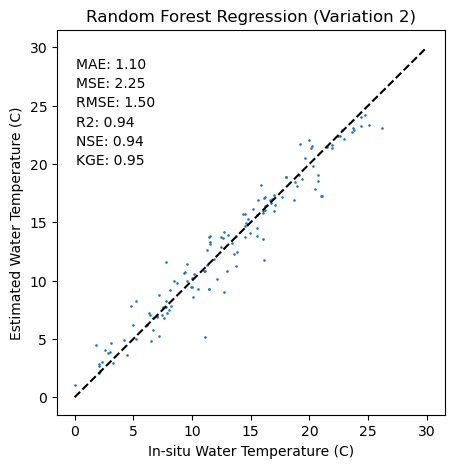

In [21]:
# scatter plot of the test results
fig, ax = plt.subplots(1,1, figsize=(5, 5))
test_set.plot.scatter(x='avg_temp(C)', y='y_pred', ax=ax, s=.75)
ax.plot([0, 30], [0, 30], color='k', linestyle='--')
ax.set_xlabel('In-situ Water Temperature (C)')
ax.set_ylabel('Estimated Water Temperature (C)')
ax.set_title('Random Forest Regression (Variation 2)')

# mae, mse, rmse, r2, nse, kge = test_results[test_results["patience"] == patience].iloc[0][['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']]
mae = test_results['MAE']
mse = test_results['MSE']
rmse = test_results['RMSE']
r2 = test_results['R2']
nse = test_results['NSE']
kge = test_results['KGE']


ax.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
ax.annotate(f'MSE: {mse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')
ax.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.8), xycoords='axes fraction')
ax.annotate(f'R2: {r2:.2f}', xy=(0.05, 0.75), xycoords='axes fraction')
ax.annotate(f'NSE: {nse:.2f}', xy=(0.05, 0.7), xycoords='axes fraction')
ax.annotate(f'KGE: {kge:.2f}', xy=(0.05, 0.65), xycoords='axes fraction')

In [ ]:
test_set2

In [ ]:
# train the model with the best hyperparameters on all the data and save it
final_model = RandomForestRegressor(n_estimators=best_hyperparameters["n_estimators"], random_state=seed)

X = ml_input_data[features]
y = ml_input_data[y_col]

final_model.fit(X, y)

dump(final_model, f"{model_name}.joblib")

['RFR2.joblib']

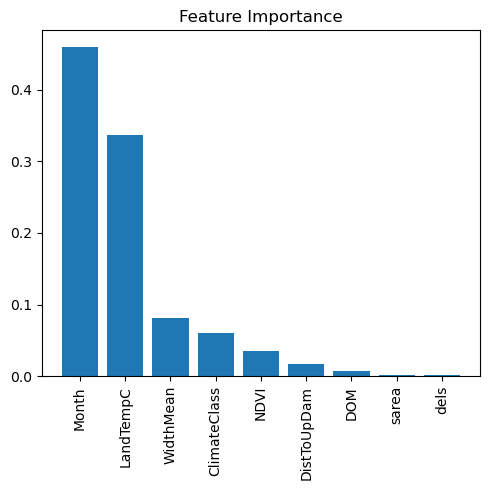

In [ ]:
# find  and plot the importance of each feature
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.bar(range(X.shape[1]), importances[indices], align="center")
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(np.array(features)[indices], rotation=90)
ax.set_title("Feature Importance")
fig.tight_layout()